In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('World-Stock-Prices-Dataset.csv')

df["Country"].unique()

array(['usa', 'germany', 'japan', 'switzerland', 'canada', 'netherlands',
       'france'], dtype=object)

In [2]:
# idk why this is here
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())


Dataset shape: (310122, 13)

Column names:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Brand_Name', 'Ticker', 'Industry_Tag', 'Country', 'Dividends', 'Stock Splits', 'Capital Gains']

First few rows:
                        Date        Open        High         Low       Close  \
0  2025-07-03 00:00:00-04:00    6.630000    6.740000    6.615000    6.640000   
1  2025-07-03 00:00:00-04:00  106.750000  108.370003  106.330101  107.339996   
2  2025-07-03 00:00:00-04:00  122.629997  123.050003  121.550003  121.930000   
3  2025-07-03 00:00:00-04:00  221.705002  224.009995  221.360001  223.410004   
4  2025-07-03 00:00:00-04:00  212.145004  214.649994  211.810104  213.550003   

       Volume Brand_Name Ticker Industry_Tag  Country  Dividends  \
0   4209664.0    peloton   PTON      fitness      usa        0.0   
1    560190.0      crocs   CROX     footwear      usa        0.0   
2     36600.0     adidas  ADDYY      apparel  germany        0.0   
3  29295154.0     amazon   AMZN   e-com

In [3]:
# questions 1-3
# changed because old code used .itterrows() which bypasses the C loops that make pandas fast
# new one should all be vectorized
#1
top_row = df.loc[df["High"].idxmax()]
print(top_row)
#2
avg = df.groupby("Brand_Name")["Volume"].mean().to_dict()
print(avg)
#3
country_counts = df["Country"].value_counts().to_dict()
print(country_counts)

Date             2024-06-18 00:00:00-04:00
Open                                3435.0
High                           3463.070068
Low                                 3370.0
Close                          3427.610107
Volume                            693800.0
Brand_Name                        chipotle
Ticker                                 CMG
Industry_Tag                          food
Country                                usa
Dividends                              0.0
Stock Splits                           0.0
Capital Gains                          NaN
Name: 18924, dtype: object
{'3m': 3480991.8792890264, 'adidas': 59576.23362175525, 'adobe': 5115460.557032458, 'airbnb': 6007634.09325562, 'amazon': 116452264.35935085, 'amd': 34004310.76893354, 'american eagle outfitters': 5032047.939258114, 'american express': 6076273.512982998, 'apple': 376723829.8304482, 'block': 10403551.52184874, 'bmw group': 12802.4037999038, 'chipotle': 1386581.7429726997, 'cisco': 41715528.26846986, 'coinbase': 

4) which company had the most volatile stock in terms of daily range (high to low gap)

In [4]:
# single pass
df['Volatility (%)'] = (df['High'] - df['Low']) / df['Low'] * 100
max_vol_row = df.loc[df['Volatility (%)'].idxmax()]
print(max_vol_row)

Date              2019-06-10 00:00:00-04:00
Open                             590.928222
High                             600.041075
Low                               67.861498
Close                             92.097748
Volume                                200.0
Brand_Name                             puma
Ticker                                PMMAF
Industry_Tag                        apparel
Country                             germany
Dividends                               0.0
Stock Splits                           10.0
Capital Gains                           NaN
Volatility (%)                   784.214303
Name: 94646, dtype: object


5) identify the companies that paid dividends at some point in the dataset

In [5]:
# for some reason it says .unique() is not a function? but it works
df[df["Dividends"] > 0]["Brand_Name"].unique()

array(['american express', 'cisco', 'jpmorgan chase & co',
       'the walt disney company', 'fedex', 'salesforce / slack',
       'southwest airlines', 'the coca-cola company', 'google',
       'the home depot', 'nike', "mcdonald's", 'johnson & johnson',
       'hilton', '3m', 'marriott', 'unilever', 'hershey company',
       'starbucks', 'microsoft', 'target', 'delta air lines', 'visa',
       'costco', 'procter & gamble', 'colgate palmolive',
       'american eagle outfitters', 'mastercard', 'nvidia', 'nordstrom',
       'apple', 'logitech', 'porsche', 'puma', 'adidas', 'bmw group',
       'lvmh', 'foot locker', 'honda', 'philips', 'toyota', 'ubisoft',
       'nintendo', 'adobe'], dtype=object)

6. which company's stock showed the greatest upward trend over time?

Brand_Name             3m
Start_Date     2000-01-03
End_Date       2025-07-03
Start_Price     16.232879
End_Price      158.235968
Increase          874.79%
Name: 0, dtype: object


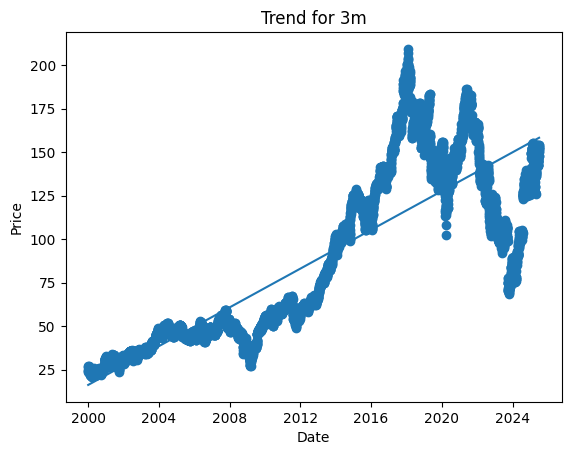

In [6]:
# fit a linear regression of close vs. date‑ordinal per company to capture its long‑term price trend
# predict the model’s start/end prices, compute % change, and select the company with the highest gain
df['Date'] = pd.to_datetime(df['Date'], utc=True)
results = []
for company, group in df.groupby('Brand_Name'):
  group = group.sort_values(by='Date')
  if len(group) < 2:
    continue
  x = group['Date'].map(pd.Timestamp.toordinal).values.reshape(-1, 1) # again not sure why it says not a function
  y = group['Close'].values

  model = LinearRegression().fit(x, y)

  start_date = x[0, 0]
  end_date = x[-1, 0]
  start_pred = model.predict([[start_date]])[0]
  end_pred = model.predict([[end_date]])[0]

  increase = (end_pred - start_pred) / start_pred * 100

  results.append({
    'Brand_Name': company,
    'Start_Date': group['Date'].iloc[0],
    'End_Date': group['Date'].iloc[-1],
    'Start_Price': start_pred,
    'End_Price': end_pred,
    'Increase': f"{increase:.2f}%",
  })

results_df = pd.DataFrame(results)
results_df['Start_Date'] = results_df['Start_Date'].dt.date
results_df['End_Date'] = results_df['End_Date'].dt.date

max_increase = results_df.loc[results_df['Increase'].idxmax()]
print(max_increase)

# visualization

best_brand = max_increase['Brand_Name']
group = df[df['Brand_Name'] == best_brand].sort_values('Date')

x_ord = group['Date'].map(pd.Timestamp.toordinal).values.reshape(-1,1)
y = group['Close'].values

model = LinearRegression().fit(x_ord, y)

x_line = np.linspace(x_ord.min(), x_ord.max(), 100)
y_line = model.predict(x_line.reshape(-1,1))
dates_line = [pd.Timestamp.fromordinal(int(d)) for d in x_line]

plt.figure()
plt.scatter(group['Date'], y)
plt.plot(dates_line, y_line)
plt.title(f'Trend for {best_brand}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


7. what was the best 5-day period to invest in each company (max gain over 5 days)?

In [7]:
## old method was O(n * number of brands) time complexity, way too slow
# new method avoids any py loops so everything's in native C in O(N) time
df = df.sort_values(['Brand_Name', 'Date'], ignore_index=True)
df['Close_5'] = df.groupby('Brand_Name')['Close'].shift(-4)
df['End_Date'] = df.groupby('Brand_Name')['Date'].shift(-4)
df['Pct5'] = (df['Close_5'] - df['Open']) / df['Open'] * 100
valid = df.dropna(subset=['Pct5'])
best_idx = valid.groupby('Brand_Name')['Pct5'].idxmax()
results = (
    valid
    .loc[best_idx, ['Brand_Name', 'Date', 'End_Date', 'Open', 'Close_5', 'Pct5']]
    .rename(columns={
        'Date': 'Start_Date',
        'Open': 'Day1_Open',
        'Close_5': 'Day5_Close',
        'Pct5': '%_Increase'
    })
    .reset_index(drop=True)
)

results['Start_Date'] = results['Start_Date'].dt.date
results['End_Date'] = results['End_Date'].dt.date
results['Day1_Open'] = results['Day1_Open'].map(lambda x: f"{x:.2f}")
results['Day5_Close'] = results['Day5_Close'].map(lambda x: f"{x:.2f}")
results['%_Increase'] = results['%_Increase'].map(lambda x: f"{x:.2f}%")

print(results)

                   Brand_Name  Start_Date    End_Date Day1_Open Day5_Close  \
0                          3m  2024-07-25  2024-07-30    102.72     126.75   
1                      adidas  2022-11-03  2022-11-09     45.55      61.51   
2                       adobe  2000-02-02  2000-02-08     13.89      20.79   
3                      airbnb  2020-12-16  2020-12-22    125.83     163.19   
4                      amazon  2001-04-06  2001-04-12      0.44       0.73   
..                        ...         ...         ...       ...        ...   
56                    ubisoft  2024-09-30  2024-10-04      2.22       3.02   
57                   unilever  2000-03-10  2000-03-16      5.59       6.51   
58                       visa  2008-10-24  2008-10-30      9.84      12.19   
59  zoom video communications  2020-08-26  2020-09-01    293.00     457.69   
60                   zoominfo  2020-06-05  2020-06-11     36.50      49.50   

   %_Increase  
0      23.39%  
1      35.05%  
2      49.72%  

see viz.ipynb for remaining two visualizations